In [72]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

In [73]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader, random_split

In [74]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print(f"using PyTorch version: {torch.__version__}, Device: {device}")

using PyTorch version: 2.2.2+cu118, Device: cuda


In [75]:
data, info = tfds.load('tf_flowers', with_info=True)
print(data, info)
data.keys()

{'train': <_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>} tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_dir='C:\\Users\\euiso\\tensorflow_datasets\\tf_flowers\\3.0.1',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    ur

dict_keys(['train'])

In [76]:
ds_train = data['train']
print(len(ds_train))

3670


In [77]:
print(len(ds_train))

ds_train = ds_train.map(lambda x:(tf.image.resize(x['image'], (224, 224)), x['label']))
ds_train = ds_train.shuffle(1000).batch(3670)
batch = next(iter(ds_train))
print(batch[0].shape, type(batch[0]), batch[1].shape, type(batch[1]))

3670
(3670, 224, 224, 3) <class 'tensorflow.python.framework.ops.EagerTensor'> (3670,) <class 'tensorflow.python.framework.ops.EagerTensor'>


In [78]:
images, labels = batch
print(images.shape, type(images), labels.shape, type(labels))

(3670, 224, 224, 3) <class 'tensorflow.python.framework.ops.EagerTensor'> (3670,) <class 'tensorflow.python.framework.ops.EagerTensor'>


In [79]:
# 만든 데이터를 확인하기 위해 그림을 그려보면

import matplotlib.pyplot as plt

label_map = {
    0 : 'dandelion',
    1 : 'daisy',
    2 : 'tulip',
    3 : 'sunflower',
    4 : 'rose'
}

images = images.numpy() / 255
labels = labels.numpy()

print(images.shape, type(images), labels.shape, type(labels))

(3670, 224, 224, 3) <class 'numpy.ndarray'> (3670,) <class 'numpy.ndarray'>


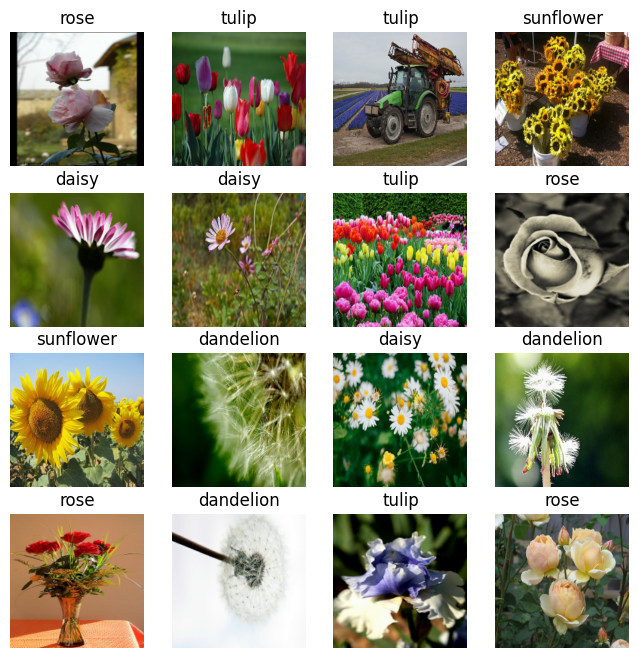

In [80]:
import random
import matplotlib.pyplot as plt

random_idx = np.random.randint(0, len(images), size=16)
plt.figure(figsize=(8, 8))
for i, idx in enumerate(random_idx):
    img = images[idx]
    label_idx = labels[idx]
    label = label_map[label_idx]
    plt.subplot(4, 4, i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
plt.show()

In [81]:
# # 이미지 크기를 조정하고 numpy 배열로 변환
# def preprocess_data(dataset):
#     images = []
#     labels = []
#     for example in dataset:
#         image = example['image'].numpy() / 255.0  # 이미지 정규화
#         label = example['label'].numpy()
#         images.append(image)
#         labels.append(label)
#     return np.array(images), np.array(labels)

# train_images, train_labels = preprocess_data(ds_train)

# print(train_images.shape, type(train_images), train_labels.shape, type(train_labels))


In [82]:
# train, test 로 나누기 위해서 슬라이싱

train_images = images[:-600]
train_labels = labels[:-600]
test_images = images[-600 :]
test_labels = labels[-600 :]

print(train_images.shape, type(train_images), train_labels.shape, type(train_labels))
print(test_images.shape, type(test_images), test_labels.shape, type(test_labels))

(3070, 224, 224, 3) <class 'numpy.ndarray'> (3070,) <class 'numpy.ndarray'>
(600, 224, 224, 3) <class 'numpy.ndarray'> (600,) <class 'numpy.ndarray'>


In [83]:
# torch tensor로 바꾸고, 모양도 (150, 150, 3) (3, 150, 150) 으로 바꾼다

import torch
train_images = torch.tensor(train_images).permute(0, 3, 1, 2)
test_images = torch.tensor(test_images).permute(0, 3, 1, 2)
train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)

print(train_images.shape, type(train_images), train_labels.shape, type(train_labels))
print(test_images.shape, type(test_images), test_labels.shape, type(test_labels))

torch.Size([3070, 3, 224, 224]) <class 'torch.Tensor'> torch.Size([3070]) <class 'torch.Tensor'>
torch.Size([600, 3, 224, 224]) <class 'torch.Tensor'> torch.Size([600]) <class 'torch.Tensor'>


In [84]:
class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

# CustomDataset 인스턴스 생성
train_dataset = CustomDataset(train_images, train_labels)
test_dataset = CustomDataset(test_images, test_labels)

In [85]:
# DataLoader 생성
batch_size = 64
train_dataset_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# DataLoader 데이터 확인
for X, y in train_dataset_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}, {type(X)}, {y.dtype}")
    print(f"Shape of y: {y.shape}, {type(y)}, {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 224, 224]), <class 'torch.Tensor'>, torch.int64
Shape of y: torch.Size([64]), <class 'torch.Tensor'>, torch.int64


In [86]:
################################################################################
###############             VGG16 Transfer Learning              ###############
################################################################################

In [87]:
pretrained_model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

print(pretrained_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [88]:
class MyTransferLearningModel(torch.nn.Module):

    def __init__(self, pretrained_model, feature_extractor):

        super().__init__()

        if (feature_extractor):
            for param in pretrained_model.parameters():
                param.require_grad = False

        # vision transformer 에서의 classifier 부분은 heads 로 지정
        pretrained_model.heads = torch.nn.Sequential(
            torch.nn.Linear(pretrained_model.classifier[0].in_features, 128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(128, 5)
        )

        self.model = pretrained_model

    def forward(self, data):

        logits = self.model(data)

        return logits 

In [89]:
feature_extractor = False  # True: Feature Extractor,  False: Fine Tuning

model = MyTransferLearningModel(pretrained_model, feature_extractor).to(device)

criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-6)

In [90]:
import torch
def model_train(dataloader, model, criterion, optimizer) :

    model.train()

    train_loss = train_correct = total_train = 0
    total_train_batch = len(dataloader)

    for images, labels in dataloader :
        x_train = images.to(device).float()
        y_train = labels.to(device)

        outputs = model(x_train)
        loss = criterion(outputs, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        total_train += y_train.size(0)
        train_correct += (outputs.argmax(1) == y_train).type(torch.float).sum().item()

        train_avg_loss = train_loss / total_train_batch
        train_avg_accuracy = 100 * train_correct / total_train

    return train_avg_loss, train_avg_accuracy

In [91]:
def model_evaluate(dataloader, model, criterion) :

    model.eval()

    test_loss = test_correct = total_test = 0
    total_test_batch = len(dataloader)

    with torch.no_grad() :

        for images, labels in dataloader :

            x_test = images.to(device).float()
            y_test = labels.to(device).long()

            outputs = model(x_test)
            loss = criterion(outputs, y_test)

            test_loss += loss.item()
            total_test += y_test.size(0)
            test_correct += (outputs.argmax(dim=1) == y_test).sum().item()

            test_avg_loss = test_loss / total_test_batch
            test_avg_correct = 100 * test_correct / total_test

        return test_avg_loss, test_avg_correct

In [92]:
from datetime import datetime

train_loss_list = []
train_accuracy_list = []

test_loss_list = []
test_accuracy_list = []

start_time = datetime.now()

epochs =30

for epoch in range(epochs) :

    train_loss, train_accuracy = model_train(train_dataset_loader, model, criterion, optimizer)
    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_accuracy)

    test_loss, test_accuracy = model_evaluate(test_dataset_loader, model, criterion )
    test_loss_list.append(test_loss)
    test_accuracy_list.append(test_accuracy)

    print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Epoch: 1, Train Loss: 8.6911, Train Accuracy: 0.6189, Test Loss: 5.7477, Test Accuracy: 2.5000
Epoch: 2, Train Loss: 4.6932, Train Accuracy: 6.0912, Test Loss: 3.3018, Test Accuracy: 14.1667
Epoch: 3, Train Loss: 3.0865, Train Accuracy: 16.9055, Test Loss: 2.3995, Test Accuracy: 29.1667
Epoch: 4, Train Loss: 2.4163, Train Accuracy: 29.3811, Test Loss: 1.8894, Test Accuracy: 39.1667
Epoch: 5, Train Loss: 1.9884, Train Accuracy: 38.3713, Test Loss: 1.5834, Test Accuracy: 45.1667
Epoch: 6, Train Loss: 1.6862, Train Accuracy: 45.6678, Test Loss: 1.3840, Test Accuracy: 49.0000
Epoch: 7, Train Loss: 1.4909, Train Accuracy: 49.6091, Test Loss: 1.2465, Test Accuracy: 53.3333
Epoch: 8, Train Loss: 1.3847, Train Accuracy: 52.5407, Test Loss: 1.1402, Test Accuracy: 56.8333
Epoch: 9, Train Loss: 1.2412, Train Accuracy: 55.8958, Test Loss: 1.0514, Test Accuracy: 61.0000
Epoch: 10, Train Loss: 1.1365, Train Accuracy: 59.0228, Test Loss: 0.9788, Test Accuracy: 62.8333
Epoch: 11, Train Loss: 1.0817, T

In [94]:
def model_test(dataloader, model):

    model.eval()

    with torch.no_grad():

        test_loss_sum = test_correct = test_total = 0

        total_test_batch = len(dataloader)

        for images, labels in dataloader:

            x_test = images.to(device)
            y_test = labels.to(device)

            outputs = model(x_test)
            loss = criterion(outputs, y_test)

            test_loss_sum += loss.item()

            test_total += y_test.size(0)
            test_correct += ((torch.argmax(outputs, 1)==y_test)).sum().item()

        test_avg_loss = test_loss_sum / total_test_batch
        test_avg_accuracy = 100*test_correct / test_total

        print('accuracy:', test_avg_accuracy)
        print('loss:', test_avg_loss)

In [95]:
model_test(test_dataset_loader, model)

accuracy: 82.66666666666667
loss: 0.4242183342576027


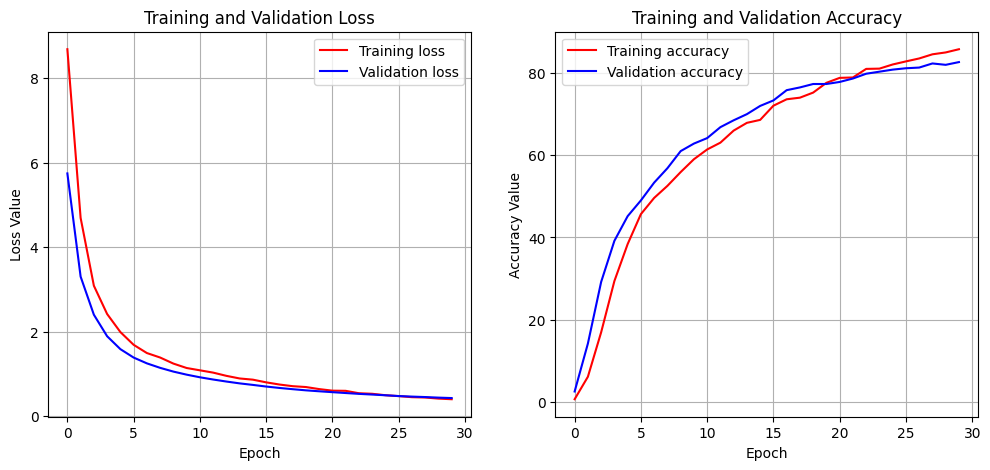

In [96]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_list, 'r', label='Training loss')
plt.plot(test_loss_list, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_list, 'r', label='Training accuracy')
plt.plot(test_accuracy_list, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.legend()
plt.grid()

plt.show()

In [ ]:
######################################################################
##################         vit_b_16                  #################
######################################################################

In [97]:
pretrained_model = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)

print(pretrained_model)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [98]:
class MyTransferLearningModel(torch.nn.Module):

    def __init__(self, pretrained_model, feature_extractor):

        super().__init__()

        if (feature_extractor):
            for param in pretrained_model.parameters():
                param.require_grad = False

        # vision transformer 에서의 classifier 부분은 heads 로 지정
        pretrained_model.heads = torch.nn.Sequential(
            torch.nn.Linear(pretrained_model.heads[0].in_features, 128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(128, 5)
        )

        self.model = pretrained_model

    def forward(self, data):

        logits = self.model(data)

        return logits

In [99]:
feature_extractor = False  # True: Feature Extractor,  False: Fine Tuning

model = MyTransferLearningModel(pretrained_model, feature_extractor).to(device)

criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-6)
     

In [100]:
import torch
def model_train(dataloader, model, criterion, optimizer) :

    model.train()

    train_loss = train_correct = total_train = 0
    total_train_batch = len(dataloader)

    for images, labels in dataloader :
        x_train = images.to(device).float()
        y_train = labels.to(device)

        outputs = model(x_train)
        loss = criterion(outputs, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        total_train += y_train.size(0)
        train_correct += (outputs.argmax(1) == y_train).type(torch.float).sum().item()

        train_avg_loss = train_loss / total_train_batch
        train_avg_accuracy = 100 * train_correct / total_train

    return train_avg_loss, train_avg_accuracy

    

In [101]:
def model_evaluate(dataloader, model, criterion) :

    model.eval()

    test_loss = test_correct = total_test = 0
    total_test_batch = len(dataloader)

    with torch.no_grad() :

        for images, labels in dataloader :

            x_test = images.to(device).float()
            y_test = labels.to(device).long()

            outputs = model(x_test)
            loss = criterion(outputs, y_test)

            test_loss += loss.item()
            total_test += y_test.size(0)
            test_correct += (outputs.argmax(dim=1) == y_test).sum().item()

            test_avg_loss = test_loss / total_test_batch
            test_avg_correct = 100 * test_correct / total_test

        return test_avg_loss, test_avg_correct

In [102]:
from datetime import datetime

train_loss_list = []
train_accuracy_list = []

test_loss_list = []
test_accuracy_list = []

start_time = datetime.now()

epochs =30

for epoch in range(epochs) :

    train_loss, train_accuracy = model_train(train_dataset_loader, model, criterion, optimizer)
    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_accuracy)

    test_loss, test_accuracy = model_evaluate(test_dataset_loader, model, criterion )
    test_loss_list.append(test_loss)
    test_accuracy_list.append(test_accuracy)

    print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

c:\Users\euiso\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


In [ ]:
model.evaluate(test_dataset_loader)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_list, 'r', label='Training loss')
plt.plot(test_loss_list, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_list, 'r', label='Training accuracy')
plt.plot(test_accuracy_list, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.legend()
plt.grid()

plt.show()